In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import pathlib

In [2]:
data = pd.read_csv("MARS_Data_20250723_080308.csv", header=1)

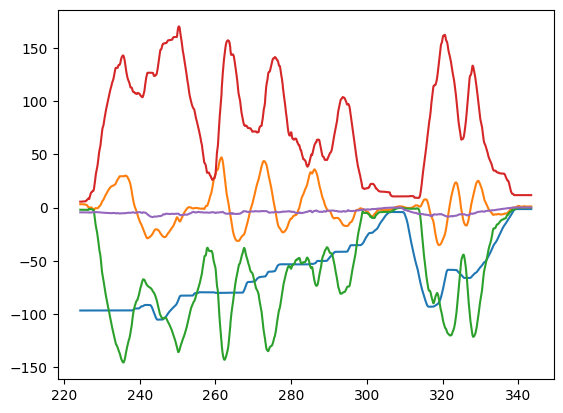

In [4]:
plt.plot(data["runTime"], data["angle1"])
plt.plot(data["runTime"], data["angle2"])
plt.plot(data["runTime"], data["angle3"])
plt.plot(data["runTime"], data["angle4"])
plt.plot(data["runTime"], data["force"])

In [5]:
angles = np.deg2rad(data[["angle1", "angle2", "angle3", "angle4"]].values)
force = data["force"].values

In [6]:
_cterms = np.cos(angles)
_sterms = np.sin(angles)
ct = lambda i: _cterms[:, i - 1]
st = lambda i: _sterms[:, i - 1]

# Build the A matrix for fitting the gravity compensation model
A = np.array([ct(1), st(1),
              ct(2) * st(1), ct(2) * ct(3) * st(1),
              st(1) * st(2), ct(3) * st(1) * st(2),
              ct(2) * st(1) * st(3), st(1) * st(2) * st(3)]).T
b = (force * np.linalg.norm(data[["epx", "epy"]].values, axis=1)).reshape(-1, 1)

In [7]:
x = np.linalg.pinv(A) @ b
x

array([[-0.00423728],
       [-1.18992423],
       [ 3.74296361],
       [ 1.19731609],
       [ 1.99763005],
       [ 0.24580473],
       [-0.16474236],
       [ 1.30690941]])

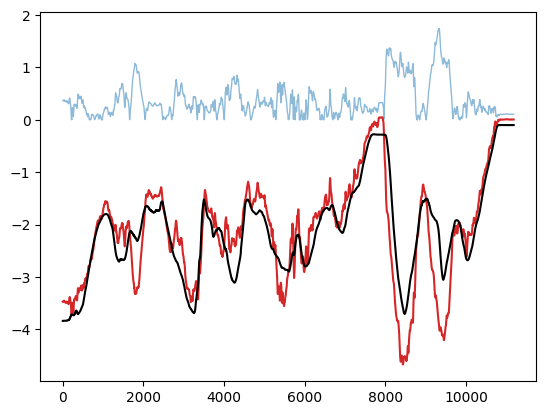

In [8]:
plt.plot(np.linalg.norm(A @ x - b, axis=1), lw=1, alpha=0.5)
plt.plot(b[:, 0], alpha=1, color="tab:red")
plt.plot(A @ x, alpha=1, color="black")

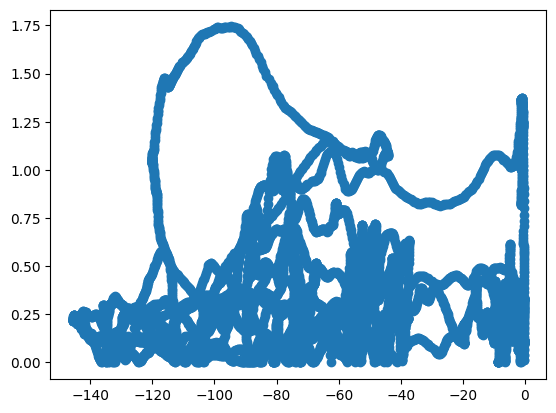

In [16]:
plt.scatter(data['angle3'], np.linalg.norm(A @ x - b, axis=1),)

### Human Limb Torque Estimation Code

In [5]:
deg2rad = lambda x: np.pi * x / 180

In [113]:
# data = pd.read_csv("MARS_Data_20250728_164539.csv", header=1)
data = pd.read_csv("MARS_Data_20250729_082458.csv", header=1)

In [115]:
try:
    inx = np.where(data["calibbtn"].values == 0)[0][-1]
except IndexError:
    inx = 0

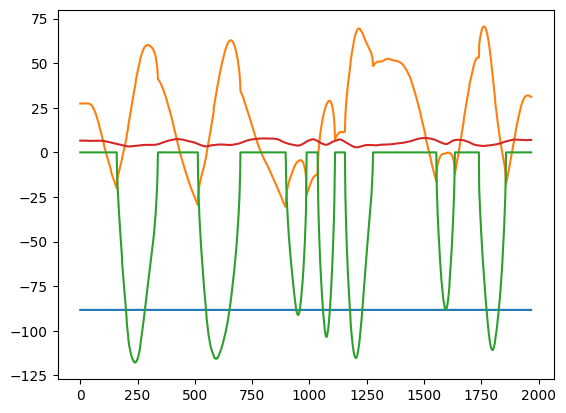

In [116]:
plt.plot(data["phi1"])
plt.plot(data["phi2"])
plt.plot(data["phi3"])
plt.plot(data["torque"])

[[-6.42864365]
 [-0.69015843]
 [-2.47130736]
 [-0.11320634]
 [-0.99006732]]


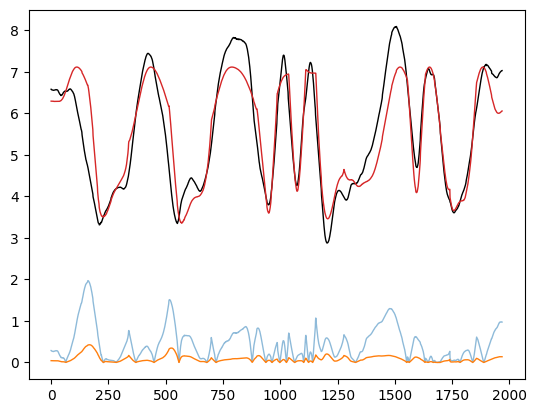

In [ ]:
_p2 = deg2rad(data['phi2'].values[inx:])
_p3 = deg2rad(data['phi3'].values[inx:])
_s1 = np.sin(deg2rad(data['phi1'].values[inx:]))
_c2 = np.cos(deg2rad(data['phi2'].values[inx:]))
_c23 = np.cos(deg2rad(data['phi2'].values[inx:] - data['phi3'].values[inx:]))
A = np.array([_s1 * _c2, _s1 * _c23, _p2 * _p3, _p2 ** 2, _p3 ** 2]).T
_y = data['torque'].values[inx:].reshape(-1, 1)
print(np.linalg.pinv(A) @ _y)

# Plot error.
_err = np.linalg.norm(A @ (np.linalg.pinv(A) @ _y) - _y, axis=1)
plt.plot(_err, lw=1, alpha=0.5)
plt.plot(_y, color="k", lw=1)
plt.plot(A @ (np.linalg.pinv(A) @ _y), color="tab:red", lw=1)
plt.plot(_err / np.abs(_y.T[0]), lw=1)

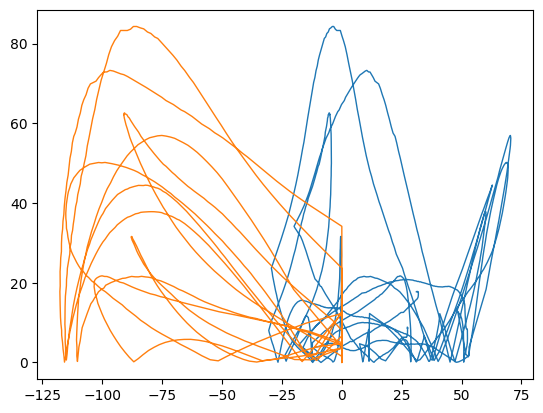

In [118]:
plt.plot(data["phi2"].values[inx:], 100 * _err / np.abs(_y.T[0]), lw=1)
plt.plot(data["phi3"].values[inx:], 100 * _err / np.abs(_y.T[0]), lw=1)

In [101]:
# Recursive least squares
N = len(_s1)
P  = np.eye(2)  # Initial covariance matrix
x = np.zeros((2, N+1))  # Initial parameter estimates
lam = 1.0
for i in range (N):
    A = np.array([[_s1[i] * _c2[i], _s1[i] * _c23[i]]]).T
    y = _y[i]
    # Kalman gain
    K = np.linalg.inv(lam + A.T @ P @ A) * (P @ A)
    # Error.
    e = y - A.T @ x[:, i]
    # Update parameters
    x[:, i+1] = x[:, i] + (K * e).T[0]
    # Update covariance matrix
    P = (lam * np.eye(2) - K @ A.T) @ P
x[:, -1]

array([-6.32262593, -0.55490044])

In [78]:
data = pd.read_csv("MARS_Data_20250729_085129.csv", header=1)

In [91]:
data

,runTime,packetNumber,status,errorString,limb,calib,limbkinparam,limbdynparam,angle1,angle2,...,phi2,phi3,imuangle1,imuangle2,imuangle3,marbtn,calibbtn,target,desired,control
0,5035.217,52102,33,NOERROR,2,1,1,0,9.584386,-0.296854,...,23.94456,0.000005,7,2,0,1,1,999,999.0,0.0
1,5035.230,52103,33,NOERROR,2,1,1,0,9.584386,-0.296854,...,23.94456,0.000005,7,1,0,1,1,999,999.0,0.0
2,5035.243,52104,33,NOERROR,2,1,1,0,9.584386,-0.296854,...,23.94456,0.000005,7,1,0,1,1,999,999.0,0.0
3,5035.256,52105,33,NOERROR,2,1,1,0,9.584386,-0.296854,...,23.94456,0.000005,6,1,0,1,1,999,999.0,0.0
4,5035.270,52106,33,NOERROR,2,1,1,0,9.584386,-0.208964,...,24.01814,0.000005,6,1,0,1,1,999,999.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5505,5108.223,57607,33,NOERROR,2,1,1,0,5.489996,-0.560526,...,23.52637,0.000005,5,1,0,1,1,999,999.0,0.0
5506,5108.236,57608,33,NOERROR,2,1,1,0,5.489996,-0.560526,...,23.52637,0.000005,5,1,0,1,1,999,999.0,0.0
5507,5108.249,57609,33,NOERROR,2,1,1,0,5.489996,-0.560526,...,23.52637,0.000005,5,1,0,1,1,999,999.0,0.0
5508,5108.263,57610,33,NOERROR,2,1,1,0,5.489996,-0.560526,...,23.52637,0.000005,5,1,0,1,1,999,999.0,0.0


(5035.0, 5045.0)

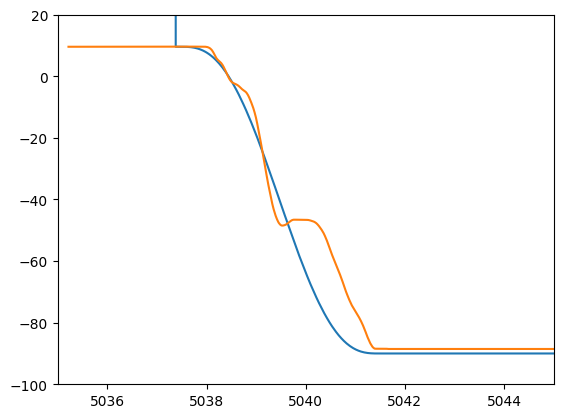

In [96]:
plt.plot(data["runTime"], data["desired"])
plt.plot(data["runTime"], data["angle1"])
plt.ylim(-100, 20)
plt.xlim(5035, 5045)

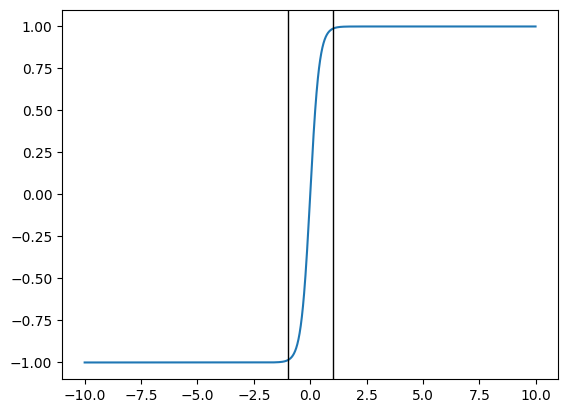

In [15]:
x = np.arange(-10, 10, 0.01)
A = 1.0
plt.plot(x, A * (1 - np.exp(-5*x/A)) / (1 + np.exp(-5*x/A)))
plt.axvline(-A, lw=1, color="k")
plt.axvline(A, lw=1, color="k")

In [ ]:
# Coefficients of a overdamped 2nd order system sampled at 0.013sec
